In [1]:
#https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# Settings -> Internet -> Phone Validation required to internet connection

!pip install imutils

In [3]:
# import the necessary packages

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import imutils
import os

In [4]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [5]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [6]:
# +Add data before loading

!wget -O gdrivedl 'https://f.mjh.nz/gdrivedl'
!ls -l
!pwd

"""
!bash /kaggle/working/gdrivedl https://drive.google.com/file/d/1JhqrLyil7JYrdf5B3359Fe8K83K1TY6S/view?usp=sharing
!bash /kaggle/working/gdrivedl https://drive.google.com/file/d/1dAt-v_GCvPEAyfjOiBxqJNP8AisdmwZn/view?usp=sharing
!ls -l /kaggle/working
inputdir = "/kaggle/working"
"""

!bash /content/gdrivedl https://drive.google.com/file/d/1JhqrLyil7JYrdf5B3359Fe8K83K1TY6S/view?usp=sharing
!bash /content/gdrivedl https://drive.google.com/file/d/1dAt-v_GCvPEAyfjOiBxqJNP8AisdmwZn/view?usp=sharing
!ls -l /content
inputdir = "/content"

--2020-12-12 23:46:35--  https://f.mjh.nz/gdrivedl
Resolving f.mjh.nz (f.mjh.nz)... 104.28.30.233, 104.28.31.233, 172.67.162.157, ...
Connecting to f.mjh.nz (f.mjh.nz)|104.28.30.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [application/octet-stream]
Saving to: ‘gdrivedl’

gdrivedl            100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-12-12 23:46:36 (28.6 MB/s) - ‘gdrivedl’ saved [1362/1362]

total 341088
-rw-r--r-- 1 root root      1362 Jan 29  2019 gdrivedl
-rw-r--r-- 1 root root   2519901 Dec 12 23:39 Pokemon_examples.zip
-rw-r--r-- 1 root root 346739983 Dec 12 23:46 Pokemon.zip
drwxr-xr-x 1 root root      4096 Dec  2 22:04 sample_data
/content
File ID: 1JhqrLyil7JYrdf5B3359Fe8K83K1TY6S
Downloading: https://docs.google.com/uc?export=download&id=1JhqrLyil7JYrdf5B3359Fe8K83K1TY6S > .399.file
Downloading: https://docs.google.com/uc?export=download&id=1JhqrLyil7JYrdf5B3359Fe8K83K1TY6S&confirm=GN0M > .399.file
Moving: .39

In [7]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
import zipfile
#imagePaths = sorted(list(paths.list_images('Pokemon')))
imagefilename = os.path.join(inputdir, 'Pokemon.zip')
zf = zipfile.ZipFile(imagefilename)
random.seed(42)
imagePaths = zf.namelist()
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [8]:
# initialize the data and labels
data = []
labels = []
from tensorflow.keras.applications import imagenet_utils
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	#image = cv2.imread(imagePath)
	image = cv2.imdecode(np.frombuffer(zf.read(imagePath), np.uint8), 1)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	#image = img_to_array(image)
	#image = np.expand_dims(image, axis=0)
	image = imagenet_utils.preprocess_input(image)
	data.append(image)
 
	# extract the class label from the image path and update the
	# labels list
	#label = imagePath.split(os.path.sep)[-2]
	label = imagePath.split('/', 1)[0]
	labels.append(label)

In [9]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 252.29MB


In [10]:
print(data.shape)
print(labels.shape)

(1168, 96, 96, 3)
(1168,)


In [11]:
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [12]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)

In [13]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

In [14]:
# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [16]:
# train the network
print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),steps_per_epoch=len(trainX) // BS,epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/100
29/29 [==============================] - 2s 76ms/step - loss: 1.4856 - accuracy: 0.5854 - val_loss: 2.1195 - val_accuracy: 0.1966
Epoch 2/100
29/29 [==============================] - 2s 68ms/step - loss: 0.8051 - accuracy: 0.7350 - val_loss: 2.1808 - val_accuracy: 0.3205
Epoch 3/100
29/29 [==============================] - 2s 69ms/step - loss: 0.5918 - accuracy: 0.8348 - val_loss: 2.2226 - val_accuracy: 0.2863
Epoch 4/100
29/29 [==============================] - 2s 68ms/step - loss: 0.5588 - accuracy: 0.8171 - val_loss: 2.1142 - val_accuracy: 0.5256
Epoch 5/100
29/29 [==============================] - 2s 69ms/step - loss: 0.5717 - accuracy: 0.8271 - val_loss: 2.1354 - val_accuracy: 0.3504
Epoch 6/100
29/29 [==============================] - 2s 69ms/step - loss: 0.6356 - accuracy: 0.8050 - val_loss: 6.1387 - val_accuracy: 0.1923
Epoch 7/100
29/29 [==============================] - 2s 68ms/step - loss: 0.4572 - accuracy: 0.8603 - val_loss: 2.5550 - 

In [17]:
import tempfile
TEMPDIR = tempfile.gettempdir()
# save the model to disk
print("[INFO] serializing network...")
model.save(os.path.join(TEMPDIR, 'cnn_keras.h5'))

[INFO] serializing network...


In [18]:
# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(os.path.join(TEMPDIR, 'cnn_keras_labelbin.pkl'), "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing label binarizer...


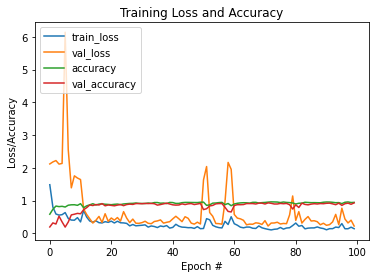

In [19]:
# plot the training loss and accuracy
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [20]:
# load the image
zf = zipfile.ZipFile(os.path.join(inputdir, 'Pokemon_examples.zip'))
#image = cv2.imread(os.path.join('Pokemon_examples', 'bulbasaur_plush.png'))
image = cv2.imdecode(np.frombuffer(zf.read('bulbasaur_plush.png'), np.uint8), 1)
output = image.copy()
exampleList = zf.namelist()

In [21]:
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [22]:
# load the trained convolutional neural network and the label
# binarizer
print("[INFO] loading network...")
model = load_model(os.path.join(TEMPDIR, 'cnn_keras.h5'))
lb = pickle.loads(open(os.path.join(TEMPDIR, 'cnn_keras_labelbin.pkl'), "rb").read())

[INFO] loading network...


In [23]:
# classify the input image
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]

[INFO] classifying image...


In [24]:
print(exampleList)
print(label)

['bulbasaur_plush.png', 'charmander_counter.png', 'charmander_hidden.png', 'mewtwo_toy.png', 'pikachu_toy.png', 'squirtle_plush.png']
squirtle


In [25]:
# we'll mark our prediction as "correct" of the input image filename
# contains the predicted label text (obviously this makes the
# assumption that you have named your testing image files this way)
#filename = os.path.join('Pokemon_examples', 'bulbasaur_plush.png')[os.path.join('Pokemon_examples', 'bulbasaur_plush.png').rfind(os.path.sep) + 1:]
filename = exampleList[exampleList.index('bulbasaur_plush.png')]
correct = "correct" if filename.rfind(label) != -1 else "incorrect"

In [26]:
print(filename)
print(correct)

bulbasaur_plush.png
incorrect


In [27]:
# build the label and draw the label on the image
label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
output = imutils.resize(output, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)

array([[[247, 249, 249],
        [228, 230, 239],
        [199, 201, 217],
        ...,
        [238, 234, 239],
        [237, 234, 239],
        [237, 235, 241]],

       [[248, 249, 249],
        [229, 231, 240],
        [199, 202, 217],
        ...,
        [202, 193, 204],
        [193, 185, 198],
        [195, 190, 205]],

       [[248, 250, 250],
        [231, 233, 242],
        [199, 202, 218],
        ...,
        [159, 149, 153],
        [118, 106, 111],
        [ 87,  78,  82]],

       ...,

       [[216, 218, 228],
        [213, 215, 225],
        [216, 218, 228],
        ...,
        [218, 222, 231],
        [211, 216, 226],
        [203, 208, 219]],

       [[214, 216, 226],
        [220, 222, 232],
        [220, 222, 232],
        ...,
        [213, 216, 227],
        [215, 219, 231],
        [212, 216, 227]],

       [[214, 216, 226],
        [219, 221, 231],
        [219, 221, 231],
        ...,
        [199, 206, 219],
        [201, 208, 221],
        [203, 211, 224]]

[INFO] squirtle: 73.16% (incorrect)


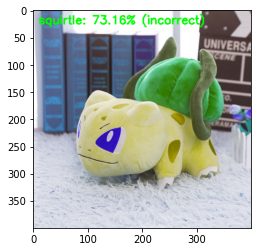

In [28]:
# show the output image
print("[INFO] {}".format(label))
img = cv2.imread('img.jpg')
plt.imshow(output)